DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


Minimum Variance backtest completed successfully.
DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


Modern Portfolio Theory backtest completed successfully.
DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


Risk Parity backtest completed successfully.
DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


Equal Weight backtest completed successfully.


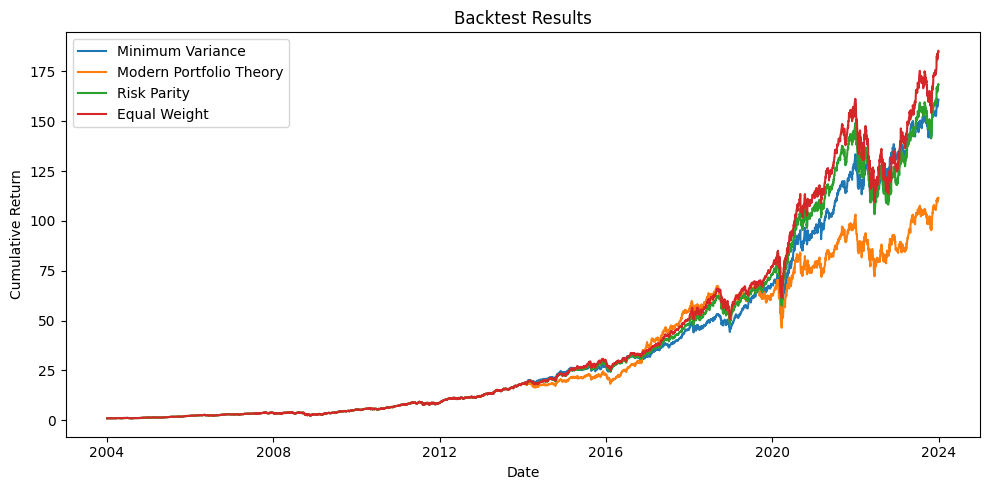

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from utils.backtesting import run_backtest  # Assuming this is a custom module for backtesting

# Use correct case for rebalance frequency
rebalance_freq = "Quarterly"  # Options: "Quarterly", "Yearly"
include_rf = False
models_selected = []
models_selected.append("Minimum Variance")
models_selected.append("Modern Portfolio Theory")
models_selected.append("Risk Parity")
models_selected.append("Equal Weight")  # Uncomment if you want to include Equal Weight model


# Function to load precomputed weights
def load_weights(method):
    # Assumes CSVs are named as 'minimum_variance_weights.csv', etc.
    path = f"data/{method}_weights.csv"
    df = pd.read_csv(path)
    # If 'Date' is not a column but is the index, reset it
    if 'Date' not in df.columns and df.index.name == 'Date':
        df = df.reset_index()
    # If wide format (Date as column, tickers as columns), set Date as index
    if 'Date' in df.columns and 'Ticker' not in df.columns:
        df = df.set_index('Date')
    return df

def load_returns():
    return pd.read_csv("data/selected_stock_daily_returns.csv", parse_dates=["Date"])

returns_df = load_returns()
performance_dict = {}

if not models_selected:
    print("No models selected for backtesting. Please select at least one model.")
else:
    for model in models_selected:
        try:
            weights_df = load_weights(model.replace(" ", "_").lower())
            # weights_df should be DataFrame with index as rebalance dates, columns as tickers, values as weights
            perf = run_backtest(returns_df, weights_df, rebalance_freq=rebalance_freq, include_rf=include_rf)
            performance_dict[model] = perf
            print(model, "backtest completed successfully.")
        except Exception as e:
            print(f"Backtest error for {model}: {e}")

    if performance_dict:
        plt.figure(figsize=(10, 5))
        for model, perf in performance_dict.items():
            plt.plot(perf.index, perf['Portfolio'], label=model)
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.title('Backtest Results')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Unable to compute backtest for selected models.")

DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


DEBUG trading_dates: DatetimeIndex(['2004-01-05', '2004-01-06', '2004-01-07', '2004-01-08',
               '2004-01-09', '2004-01-12', '2004-01-13', '2004-01-14',
               '2004-01-15', '2004-01-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5032, freq=None) Length: 5032


/workspaces/portfolio-optimization/utils/backtesting.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w = weights_df.loc[last_date].reindex(returns_wide.columns).fillna(0).values


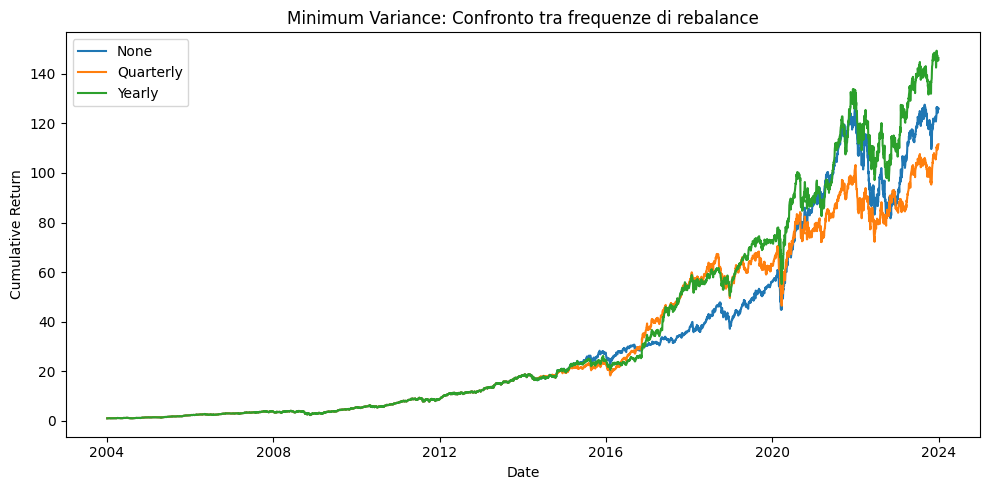

In [16]:
# Analisi confronto tra diverse frequenze di rebalance per Minimum Variance
import matplotlib.pyplot as plt
import pandas as pd
from utils.backtesting import run_backtest

def load_weights(method):
    path = f"data/{method}_weights.csv"
    df = pd.read_csv(path)
    if 'Date' not in df.columns and df.index.name == 'Date':
        df = df.reset_index()
    if 'Date' in df.columns and 'Ticker' not in df.columns:
        df = df.set_index('Date')
    return df

def load_returns():
    return pd.read_csv("data/selected_stock_daily_returns.csv", parse_dates=["Date"])

returns_df = load_returns()
weights_df = load_weights("modern_portfolio_theory")

freqs = ["None", "Quarterly", "Yearly"]
results = {}
for freq in freqs:
    perf = run_backtest(returns_df, weights_df, rebalance_freq=freq, include_rf=False)
    results[freq] = perf

plt.figure(figsize=(10, 5))
for freq, perf in results.items():
    plt.plot(perf.index, perf['Portfolio'], label=freq)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Minimum Variance: Confronto tra frequenze di rebalance')
plt.legend()
plt.tight_layout()
plt.show()